# Practical Work [PR] Notebook
This notebook contains the Network Architectures and Data Evaluation Systems for the Project. The data from the dataset is already processed in the notebook `ChordExtractorWithStatistics.ipnb` and saved to `chords.data`. Also, some Statistics can be found there. If there is any concern how the data has been processed, look into the notebook - all is done there. It also uses functions from `functions/utils.py`, such that the code is more readable and not cluttured. 

**Brief Overview Of this Notebook:**

1. **Data Preparation**: Load the data from `chords.data`, split it into training and validation sets, and create data loaders.
2. **Model Building (GRU)**: Define the GRU-based RNN architecture.
3. **Model Building (LSTM)**: Define the LSTM-based RNN architecture.
4. **Results**: Look at generated Data and Discuss it.

## 1. Data Preparation
### 1.1 Load Chords from Dataset
Load chords from file `chords.data` in a json like format.

In [1]:
# all imports 
import torch.nn as nn
import json
import torch
import random
import numpy as np
from collections import Counter
from tqdm import tqdm
from scipy.spatial import distance
from scipy.spatial.distance import jensenshannon
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F
import pretty_midi

In [2]:
def load_chords(file_path):
    """
    Loads chords from a file and returns them as a 2D list.
    """
    with open(file_path, "r") as file:
        # Read the entire file as a string
        data_str = file.read()
        
        # Convert the string representation of lists into actual lists using json.loads
        chords_2d_list = json.loads(data_str)
        
    return chords_2d_list

# Test the function
all_chords = load_chords("chords.data")
print(all_chords[:1])  # Displaying the first chord sequence for verification

[['<BOS>', 'B-:min', 'D:maj', 'G:maj', 'G:maj', 'B-:min', 'D:maj', 'G:maj', 'D:maj', 'G:maj', 'B:maj', 'B:maj', 'E:min', 'E:min', 'A:maj', 'A-:maj', 'A:maj', 'D:maj', 'D:maj', 'B-:min', 'D:maj', 'G:maj', 'G:maj', 'A-:maj', 'G:maj', 'C:min', 'C:min', 'G:maj', 'G:maj', 'B-:min', 'D:maj', 'G:maj', 'D:maj', 'G:maj', '<EOS>']]


### 1.2 Examine the Data
Getting used to the data we are working with.

In [3]:
from functions.utils import encode_chords

chord_vocab, chord_to_idx, idx_to_chord, padded_sequences, vocab_size = encode_chords(all_chords)

print("Shape of sequnces(elements, lenght):", padded_sequences.shape)
print("Vocab size (all occuring chords + 2 tokens): ", vocab_size)
print("Chord vocab:------\n", chord_vocab, "\n--------------------")

print("Index of BOS:", chord_to_idx['<BOS>'])
print("Index of EOS:", chord_to_idx['<EOS>'])
print(chord_to_idx)

Shape of sequnces(elements, lenght): torch.Size([1186, 196])
Vocab size (all occuring chords + 2 tokens):  27
Chord vocab:------
 ['<BOS>', '<EOS>', 'A-:maj', 'A-:min', 'A:maj', 'A:min', 'B-:maj', 'B-:min', 'B:maj', 'B:min', 'C:maj', 'C:min', 'D-:maj', 'D-:min', 'D:maj', 'D:min', 'E-:maj', 'E-:min', 'E:maj', 'E:min', 'F:maj', 'F:min', 'G-:maj', 'G-:min', 'G:maj', 'G:min'] 
--------------------
Index of BOS: 1
Index of EOS: 2
{'<BOS>': 1, '<EOS>': 2, 'A-:maj': 3, 'A-:min': 4, 'A:maj': 5, 'A:min': 6, 'B-:maj': 7, 'B-:min': 8, 'B:maj': 9, 'B:min': 10, 'C:maj': 11, 'C:min': 12, 'D-:maj': 13, 'D-:min': 14, 'D:maj': 15, 'D:min': 16, 'E-:maj': 17, 'E-:min': 18, 'E:maj': 19, 'E:min': 20, 'F:maj': 21, 'F:min': 22, 'G-:maj': 23, 'G-:min': 24, 'G:maj': 25, 'G:min': 26, 'pad': 0}


### 1.3 Split Train and Validation
Before proceeding with the model, we split our dataset into a training set and a validation set. This will help us evaluate our model's performance on unseen data. This will be archived with pytorch dataloaders. We'll convert our dataset to PyTorch tensors and then create data loaders for training and validation sets.

In [4]:
# Define a custom dataset
class ChordDataset(Dataset):
    def __init__(self, padded_sequences):
        self.data = padded_sequences

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sequence = self.data[idx]
        
        # Compute the original length of the sequence (without padding) for pack sequence
        length = (sequence != 0).sum().item()  # Count non-zero tokens
        
        # Using the current token to predict the next token
        # So, we return (sequence[:-1], sequence[1:], length - 1)
        # We subtract 1 from the length because we're returning sequence[:-1] which has one token less
        return sequence[:-1], sequence[1:], length - 1

# Create dataset
dataset = ChordDataset(padded_sequences)

# Split the dataset into training and validation sets (80% train, 20% validation)
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## 2. Model Architecture (GRU)

Let's define our GRU-based RNN model:

**Architecture**:
- **Embedding Layer**: We use an embedding layer to convert the integer chord encodings into continuous vectors. This will allow the model to learn a dense representation of each chord.
- **GRU Layer**: The Gated Recurrent Unit (GRU) is a type of RNN that has gating mechanisms. It's simpler than an LSTM and we will compare them later.
- **Linear Layer**: A linear layer to map the GRU outputs to the size of our vocabulary.


### 2.1 PyTorch Implementation
Using PyTorch, this can be defined very easily:

In [5]:
class ChordRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout=0.5):
        super(ChordRNN, self).__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # GRU layer
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=n_layers, dropout=dropout, batch_first=True)
        
        # Linear layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, lengths, hidden=None):
        # x: (batch_size, sequence_length)
        embedded = self.embedding(x)  # (batch_size, sequence_length, embedding_dim)
        
        # Pack the embedded sequences
        packed_embedded = pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        
        # GRU output
        packed_output, hidden = self.gru(packed_embedded, hidden)
        
        # Unpack the output
        output, output_lengths = pad_packed_sequence(packed_output, batch_first=True, total_length=x.size(1)) 
        
        # Linear layer
        output = self.fc(output)  # (batch_size, sequence_length, output_dim)
        
        return output, hidden


# Hyperparameters
#num_epochs = 100
#embedding_dim = 128
#hidden_dim = 256
#output_dim = vocab_size
#n_layers = 5

# Hyperparameters v2
num_epochs = 100
embedding_dim = 12
hidden_dim = 24
output_dim = vocab_size
n_layers = 2


# Initialize the model
model = ChordRNN(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout=0.2)
model

ChordRNN(
  (embedding): Embedding(27, 12)
  (gru): GRU(12, 24, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=24, out_features=27, bias=True)
)

### 2.2 Train function
This one will be used for both models. Cross entrophy will be used and the optimizer will be adam.

In [6]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Loss and optim
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Modified training function
def train_model(model, train_loader, val_loader, epochs, optimizer, criterion):
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(epochs):
        # Placeholder for accumulating batch losses
        batch_train_losses = []
        
        # Training
        model.train()
        for (input_seq, target_seq, lengths) in train_loader:
            input_seq, target_seq, lengths = input_seq.to(device), target_seq.to(device), lengths.to("cpu")
            optimizer.zero_grad()

            output, _ = model(input_seq, lengths)

            # Reshape output and target_seq for loss computation
            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            target_seq = target_seq.contiguous().view(-1)

            loss = criterion(output, target_seq)

            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        # Calculate average training loss for the epoch
        epoch_train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(epoch_train_loss)

        batch_val_losses = []

        # Validation
        model.eval()
        with torch.no_grad():
            for (input_seq, target_seq, lengths) in val_loader:
                input_seq, target_seq, lengths = input_seq.to(device), target_seq.to(device), lengths.to("cpu")

                output, _ = model(input_seq, lengths)

                # Reshape output and target_seq for loss computation
                output_dim = output.shape[-1]
                output = output.contiguous().view(-1, output_dim)
                target_seq = target_seq.contiguous().view(-1)

                val_loss = criterion(output, target_seq)
                batch_val_losses.append(val_loss.item())

            # Calculate average validation loss for the epoch
            epoch_val_loss = sum(batch_val_losses) / len(batch_val_losses)
            val_losses.append(epoch_val_loss)

        # Print average training and validation loss for the epoch
        if epoch % 2 == 0:
            print(f"Epoch {epoch+1}/{epochs}: Train Loss: {epoch_train_loss:.4f} | Validation Loss: {epoch_val_loss:.4f}")

    return train_losses, val_losses


# Train the GRU model
train_losses_gru, val_losses_gru = train_model(model, train_loader, val_loader, num_epochs, optimizer, criterion)

Epoch 1/100: Train Loss: 3.0286 | Validation Loss: 2.8762
Epoch 3/100: Train Loss: 2.5563 | Validation Loss: 2.4399
Epoch 5/100: Train Loss: 2.1597 | Validation Loss: 2.0584
Epoch 7/100: Train Loss: 1.8243 | Validation Loss: 1.7370
Epoch 9/100: Train Loss: 1.5403 | Validation Loss: 1.4665
Epoch 11/100: Train Loss: 1.3089 | Validation Loss: 1.2525
Epoch 13/100: Train Loss: 1.1295 | Validation Loss: 1.0857
Epoch 15/100: Train Loss: 0.9925 | Validation Loss: 0.9620
Epoch 17/100: Train Loss: 0.8927 | Validation Loss: 0.8704
Epoch 19/100: Train Loss: 0.8191 | Validation Loss: 0.8035
Epoch 21/100: Train Loss: 0.7643 | Validation Loss: 0.7549
Epoch 23/100: Train Loss: 0.7223 | Validation Loss: 0.7162
Epoch 25/100: Train Loss: 0.6895 | Validation Loss: 0.6876
Epoch 27/100: Train Loss: 0.6647 | Validation Loss: 0.6657
Epoch 29/100: Train Loss: 0.6430 | Validation Loss: 0.6470
Epoch 31/100: Train Loss: 0.6269 | Validation Loss: 0.6334
Epoch 33/100: Train Loss: 0.6132 | Validation Loss: 0.6222
Ep

### 2.3 Evaluate
Evaluate on the whole evaluation set.

In [7]:
def evaluate(model, iterator, criterion, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for (input_seq, target_seq, lenghts) in iterator:
            input_seq, target_seq, lenghts = input_seq.to(device), target_seq.to(device), lenghts.to("cpu")
            
            output, _ = model(input_seq, lenghts)
            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            target_seq = target_seq.contiguous().view(-1)
            
            loss = criterion(output, target_seq)
            
            total_loss += loss.item()

    return total_loss / len(iterator)

val_loss = evaluate(model, val_loader, criterion, device)
print("Evaluation Loss (GRU) on whole validation set: ", val_loss)

Evaluation Loss (GRU) on whole validation set:  0.548899233341217


### 2.5 Generate new Sequnces
After training our model, we will now use it and generate new sequnces.

**Multinomial sampling**:

torch.multinomial() function samples values from a multinomial distribution. The function takes in a tensor of probabilities (probs) and an integer which indicates how many samples to draw. In the case of torch.multinomial(probs, 1), it's drawing one sample based on our probabilities.

A intuitive way of understanding it:
- Imagine you have a weighted dice, where each face of the dice has a different probability of landing face up.
- If you  roll this dice, the face that lands up is sampled based on the weights (or probabilities) associated with each face.
- torch.multinomial() is doing a similar thing: given a set of probabilities (weights), it's "rolling the dice" and returning which "face" (index) was chosen.

This introduces randomness because, like rolling a weighted dice, you're not guaranteed to get the same outcome every time, even though some outcomes are more probable than others.

In [8]:
def generate_sequence(model, start_token, max_length, device, argmax:bool=False):
    model.eval()
    
    generated_sequence = [start_token]
    input_seq = torch.LongTensor([start_token]).unsqueeze(0).to(device)
    length = torch.tensor([1]).to("cpu")  # initial length is 1
    
    with torch.no_grad():
        for _ in range(max_length):
            output, _ = model(input_seq, length)
            
            # Take the last token's probabilities
            probabilities = nn.functional.softmax(output[0][-1], dim=0).to(device)
            
            # Sample a token from the distribution
            next_token = torch.multinomial(probabilities, 1).item()
            
            # xor use argmax
            if argmax:
                probabilities = nn.functional.softmax(output[0][-1], dim=0)
                next_token = torch.argmax(probabilities).item()

            if next_token == 2:  # Check for <EOS>
                break
            
            generated_sequence.append(next_token)
            input_seq = torch.LongTensor(generated_sequence).unsqueeze(0).to(device)
            length = torch.tensor([len(generated_sequence)]).to("cpu")  # update the length
    
    return generated_sequence


def map_sequence(sequnce, ignore_tokens:bool=True):
    str_sequnce = []
    for s in sequnce:
        str_sequnce.append(idx_to_chord[s])

    if ignore_tokens:
        return str_sequnce[1:-1]
    else:
        return str_sequnce

print(map_sequence(generate_sequence(model, 1, 1000, device, argmax=False)))

GRU_chords_generated = []
for _ in tqdm(range(1000)):
    GRU_chords_generated.append(map_sequence(generate_sequence(model, 1, 1000, device, argmax=False)))

['B-:maj', 'B-:maj', 'E:maj', 'A:maj', 'D:maj', 'G:maj', 'F:maj', 'F:maj', 'F:maj', 'A:maj', 'E-:maj', 'D:maj', 'D-:maj', 'C:maj', 'F:maj', 'F:maj', 'F:maj', 'F:min', 'B-:maj', 'E-:maj', 'E-:maj', 'B-:maj', 'B-:maj', 'D:maj', 'D:maj', 'F:maj', 'G:min', 'F:maj', 'D:maj', 'G:min', 'G:min', 'F:maj', 'B-:maj']


100%|███████████████████████████████████████| 1000/1000 [00:48<00:00, 20.42it/s]


## 3. Model Architecture (LSTM)
Lets now try the same thing with a LSTM. We will also measure the scores on the same validation set which comes in handy. Since measuring the performance is hard, we have now a way of quantifing the results better.

### 3.1 Set up LSTM
We will use an embedding layer to represent the integer-encoded chords as dense vectors, followed by an LSTM layer, and then a fully connected layer to produce the predictions for the next chord in the sequence.

Our LSTM model consists of the following layers:

- Embedding Layer: This converts our integer-encoded chords into dense vectors of fixed size. The embedding layer is beneficial as it allows the model to learn meaningful representations of the chords during training.
- LSTM Layer: This layer contains the LSTM cells. We also have n_layers = 2, meaning our LSTM has 2 stacked layers.
- Fully Connected Layer: The output from the LSTM layer is passed through a fully connected layer to produce predictions for the next chord in the sequence. The output size is vocab_size which is the size of our vocabulary (including padding and start end tokens
  ).

In [9]:
class ChordLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout=0.5):
        super(ChordLSTM, self).__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # GRU layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, dropout=dropout, batch_first=True)
        
        # Linear layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, lengths, hidden=None):
        # x: (batch_size, sequence_length)
        embedded = self.embedding(x)  # (batch_size, sequence_length, embedding_dim)
        
        # Pack the embedded sequences
        packed_embedded = pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        
        # GRU output
        packed_output, hidden = self.lstm(packed_embedded, hidden)
        
        # Unpack the output
        output, output_lengths = pad_packed_sequence(packed_output, batch_first=True, total_length=x.size(1)) 
        
        # Linear layer
        output = self.fc(output)  # (batch_size, sequence_length, output_dim)
        
        return output, hidden

# Initialize the model
model = ChordLSTM(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout=0.2)
model

ChordLSTM(
  (embedding): Embedding(27, 12)
  (lstm): LSTM(12, 24, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=24, out_features=27, bias=True)
)

### 3.2 Train model
Now, we'll train our LSTM model. For training, we'll use:
- Loss Function: CrossEntropyLoss, as this is a classification problem where we predict the next chord in the sequence.
- Optimizer: Adam optimizer, which adapts the learning rate during training and is effective for deep learning models.

In [10]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# train
train_losses_lstm, val_losses_lstm = train_model(model, train_loader, val_loader, num_epochs, optimizer, criterion) 

Epoch 1/100: Train Loss: 3.1412 | Validation Loss: 3.0108
Epoch 3/100: Train Loss: 2.7229 | Validation Loss: 2.6055
Epoch 5/100: Train Loss: 2.3113 | Validation Loss: 2.2039
Epoch 7/100: Train Loss: 1.9517 | Validation Loss: 1.8619
Epoch 9/100: Train Loss: 1.6586 | Validation Loss: 1.5870
Epoch 11/100: Train Loss: 1.4255 | Validation Loss: 1.3572
Epoch 13/100: Train Loss: 1.2239 | Validation Loss: 1.1737
Epoch 15/100: Train Loss: 1.0785 | Validation Loss: 1.0381
Epoch 17/100: Train Loss: 0.9671 | Validation Loss: 0.9364
Epoch 19/100: Train Loss: 0.8847 | Validation Loss: 0.8611
Epoch 21/100: Train Loss: 0.8233 | Validation Loss: 0.8062
Epoch 23/100: Train Loss: 0.7763 | Validation Loss: 0.7641
Epoch 25/100: Train Loss: 0.7401 | Validation Loss: 0.7301
Epoch 27/100: Train Loss: 0.7101 | Validation Loss: 0.7020
Epoch 29/100: Train Loss: 0.6870 | Validation Loss: 0.6817
Epoch 31/100: Train Loss: 0.6666 | Validation Loss: 0.6643
Epoch 33/100: Train Loss: 0.6506 | Validation Loss: 0.6487
Ep

### 3.3 Evaluate
Evaluate on the whole evaluation set.

In [11]:
val_loss = evaluate(model, val_loader, criterion, device)
print("Evaluation Loss (LSTM) on whole validation set: ", val_loss)

Evaluation Loss (LSTM) on whole validation set:  0.5478938519954681


### 3.4 Generate new Sequnces
Same as in 2.5. We generate new Sequcnes now.

In [12]:
# Generate a new musical chord sequence using the trained model
generated_seq = map_sequence(generate_sequence(model, 1, 1000, device, argmax=False))
print(generated_seq)

# now lets generate 1000 LSTM Chord sequnces
LSTM_chords_generated = []
for _ in tqdm(range(1000)):
    LSTM_chords_generated.append(map_sequence(generate_sequence(model, 1, 1000, device, argmax=False)))

['D:maj', 'D:maj', 'G:maj', 'G:maj', 'G:maj', 'G-:maj', 'G-:maj', 'C:maj', 'F:maj', 'G:maj', 'A:maj', 'D:maj', 'G:maj', 'G:maj', 'G:maj', 'A:maj', 'D:maj', 'D:maj', 'D:maj', 'G:maj', 'E:min', 'A-:min', 'D-:maj', 'G-:min', 'G:maj', 'G-:min', 'C:maj', 'G-:min', 'G-:maj', 'E:min', 'A:maj', 'D:maj', 'G-:min', 'F:min', 'C:maj', 'E-:maj', 'C:maj', 'G:maj', 'C:maj', 'F:maj', 'B-:maj', 'E-:maj', 'D:maj', 'G:maj', 'G:maj', 'B:maj', 'E:maj', 'A:maj', 'A:maj', 'D:maj', 'G:maj', 'G:maj', 'C:maj', 'A-:maj', 'B:maj', 'E:min', 'B-:maj', 'A:min', 'D:maj', 'D-:maj', 'G:maj', 'D-:maj', 'G:maj', 'C:maj', 'E:min', 'A:maj', 'D:min', 'E-:maj', 'G:maj', 'G:maj', 'E:min', 'E:maj', 'A:maj', 'D:maj', 'G:maj', 'E-:maj', 'D:min', 'G:maj', 'C:maj', 'G:maj', 'C:maj', 'D:maj', 'A-:maj', 'F:maj', 'D:min', 'G:maj', 'C:maj', 'D:maj', 'D:maj', 'G:maj']


100%|███████████████████████████████████████| 1000/1000 [00:51<00:00, 19.29it/s]


## 4. Results

### 4.1 Compare losses 
Lets compare the losses of each network over the epochs. We wil also consider the validation losses.

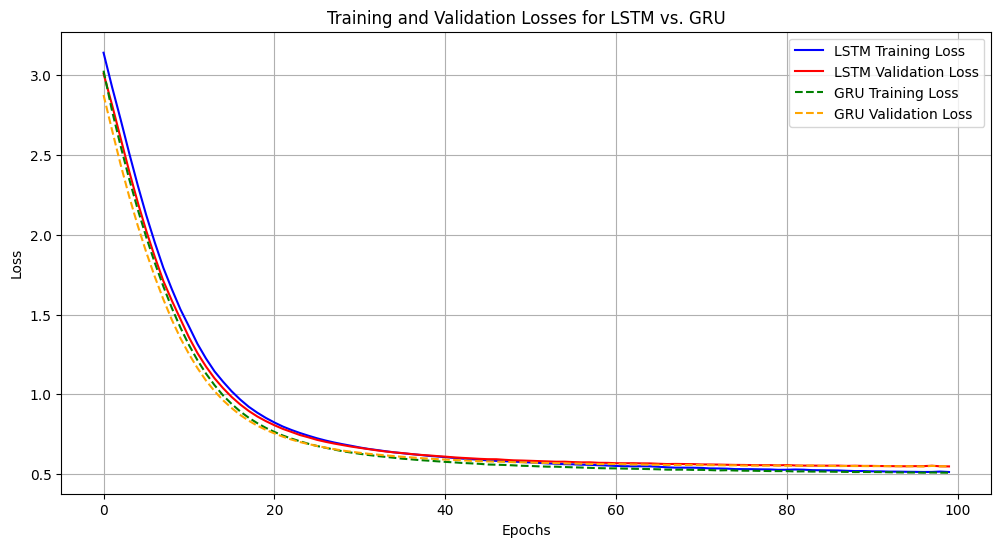

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train_losses_lstm, label='LSTM Training Loss', color='blue')
plt.plot(val_losses_lstm, label='LSTM Validation Loss', color='red')
plt.plot(train_losses_gru, '--', label='GRU Training Loss', color='green')
plt.plot(val_losses_gru, '--', label='GRU Validation Loss', color='orange')
plt.title('Training and Validation Losses for LSTM vs. GRU')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.savefig('img/train_results_compare-50epochs.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.2 Chord Distribution analysis
Lets dive into our generated sequnces and look at some important things of our data.

#### 4.2.1 Chord Distribution similartity 
This function will give a similarity score (**Jensen-Shannon**) between the generated chord distribution and the reference chord distribution. A score of 1 means they are identical, and a score of 0 means they are completely different.

In [14]:
def chord_distribution_similarity(generated_chords, reference_chords, chord_mapping):
    """
    Compares the distribution of generated chords with a reference distribution using Jensen-Shannon distance.
    
    Parameters:
    - generated_chords: List of chord progressions from the model.
    - reference_chords: List of reference chord progressions.
    - chord_mapping: Dictionary mapping chord names to indices.
    
    Returns:
    - similarity_score: A value between 0 and 1 indicating the similarity 
                        between the distributions (1 means they are identical).
    """
    
    # Flatten the chord progressions into a single list
    generated_flat = [chord for progression in generated_chords for chord in progression]
    reference_flat = [chord for progression in reference_chords for chord in progression]
    
    # Get frequency distributions
    generated_freq = Counter(generated_flat)
    reference_freq = Counter(reference_flat)
    
    # Convert chord frequencies to probability vectors
    num_chords = len(chord_mapping)
    generated_probs = [generated_freq.get(chord, 0) / len(generated_flat) for chord in chord_mapping.keys()]
    reference_probs = [reference_freq.get(chord, 0) / len(reference_flat) for chord in chord_mapping.keys()]
    
    # Calculate Jensen-Shannon distance using scipy
    js_distance = jensenshannon(generated_probs, reference_probs)
    
    # Convert the distance to a similarity score
    similarity_score = 1 - js_distance
    
    return similarity_score

    
# for testing
print("Test similartity function: ", chord_distribution_similarity([["A:min", "A:min"], ["A:min", "A:min"]], [["A:min", "A:min"], ["A:min", "B:min"]], chord_to_idx))
print("GRU Similartity to dataset: ", chord_distribution_similarity(GRU_chords_generated, all_chords, chord_to_idx))
print("LSTM Similartity to dataset: ", chord_distribution_similarity(LSTM_chords_generated, all_chords, chord_to_idx))

Test similartity function:  0.690803316726986
GRU Similartity to dataset:  0.8786975884873459
LSTM Similartity to dataset:  0.8795344868289562


#### 4.2.2 Padding token content
The padding tokens are sometimes prediced (especially for the LSTM). lets see how many times we predict it.

In [15]:
def percentage_of_pads(data):
    """
    Calculates the percentage of "pad" tokens in the data.

    Parameters:
    - data: 2D list containing sequences of strings.

    Returns:
    - Percentage of "pad" tokens in the data.
    """
    
    total_elements = sum(len(sequence) for sequence in data)
    pad_count = sum(sequence.count("pad") for sequence in data)
    
    return (pad_count / total_elements) 


gru_pad_percentage = percentage_of_pads(GRU_chords_generated)
lstm_pad_percentage = percentage_of_pads(LSTM_chords_generated)

print("Padding predicted by GRU: " , gru_pad_percentage)
print("Padding predicted by LSTM: " , lstm_pad_percentage)

Padding predicted by GRU:  0.0002478212382801206
Padding predicted by LSTM:  5.946599536165236e-05


#### 4.2.3 Maj/Min Percentages 
Lets compare the percentage of maj/min chords in our generated dataset with the original ones and new ones. 

In [16]:
def percentage_of_min_maj(data):
    """
    Calculates the percentage of ":min" and ":maj" tokens in the data.

    Parameters:
    - data: 2D list containing sequences of strings.

    Returns:
    - Tuple containing (Percentage of ":min" tokens, Percentage of ":maj" tokens) in the data.
    """
    # exclude pad, bos and eos tokens
    total_elements = sum(1 for sequence in data for chord in sequence if chord not in ["pad", "<BOS>", "<EOS>"])

    min_count = sum(chord.endswith(":min") for sequence in data for chord in sequence)
    maj_count = sum(chord.endswith(":maj") for sequence in data for chord in sequence)
    
    return (min_count / total_elements) * 100, (maj_count / total_elements) * 100

gru_min_percentage, gru_maj_percentage = percentage_of_min_maj(GRU_chords_generated)
lstm_min_percentage, lstm_maj_percentage = percentage_of_min_maj(LSTM_chords_generated)
ori_min_percentage, ori_maj_percentage = percentage_of_min_maj(all_chords)


print("GRU minor chord percentage: ",gru_min_percentage,  "| GRU major chord percentage: ", gru_maj_percentage)
print("LSTM minor chord percentage: ",lstm_min_percentage,  "| LSTM major chord percentage: ", lstm_maj_percentage)
print("original minor chord percentage: ",ori_min_percentage,  "| Original major chord percentage: ", ori_maj_percentage)

GRU minor chord percentage:  31.750950256156006 | GRU major chord percentage:  68.249049743844
LSTM minor chord percentage:  30.00297353553375 | LSTM major chord percentage:  69.99702646446624
original minor chord percentage:  31.10197256159989 | Original major chord percentage:  68.8980274384001


### 4.3 Exporting Sequences as MIDI

In this section, we'll utilize the Python library `pretty_midi` to export our chord sequences into MIDI files. These files can be played using the Windows media player or imported into any Digital Audio Workstation (DAW) for playback and further processing.

#### 4.3.1 Output Chords only
Here, we will output the chord progression with the instrument piano.

In [17]:
def chord_to_notes(chord_name):
    """Converts a chord to a list of the notes (integers) for defining ther chord as midi. Values see below. Only works for the smaller vocab size."""
    note_name_to_num = {
        'C': 60, 'C#': 61, 'D': 62, 'D#': 63, 'E': 64, 'F': 65, 
        'F#': 66, 'G': 67, 'G#': 68, 'A': 69, 'A#': 70, 'B': 71,
        'E-': 63, 'A-': 68, 'B-': 70, 'D-': 61, 'G-': 66  # Adding the flat notes
    }
    
    # Extract the root note and the type (major/minor) from the chord name
    root = chord_name.split(':')[0]
    chord_type = chord_name.split(':')[-1]
    
    # Calculate the MIDI numbers for the root, third, and fifth notes
    root_num = note_name_to_num[root]
    third_num = root_num + 4 if chord_type == 'maj' else root_num + 3
    fifth_num = root_num + 7
    
    return [root_num, third_num, fifth_num]

def progression_to_midi(chord_progression, filename='output.mid'):
    """Creates a midi file and saves it."""
    # Create a new PrettyMIDI object
    midi_data = pretty_midi.PrettyMIDI(initial_tempo=80)
    
    # Create an instrument instance for a piano (instrument number 0)
    piano_program = pretty_midi.instrument_name_to_program('Acoustic Grand Piano')
    piano = pretty_midi.Instrument(program=piano_program)
    
    # Iterate over the chord progression and add each chord to the MIDI file
    for i, chord in enumerate(chord_progression):
        if chord not in ['<BOS>', '<EOS>', 'pad']:  # Ignore these tokens
            start_time = i  # Start time of the chord (each chord lasts for 1 time unit)
            end_time = i + 1  # End time of the chord
            notes = chord_to_notes(chord)  # Get the MIDI notes for the chord
            for note_num in notes:
                # Create a new Note instance for each note in the chord
                note = pretty_midi.Note(velocity=100, pitch=note_num, start=start_time, end=end_time)
                piano.notes.append(note)
    
    # Add the piano instrument to the PrettyMIDI object
    midi_data.instruments.append(piano)
    
    # Write out the MIDI data to a file
    midi_data.write(filename)


# Test the function
chord_progression = ['C:min', 'C:maj', 'A-:maj']
progression_to_midi(chord_progression, "midi/test.mid")

In [18]:
def save_random_progression_to_midi(chord_progressions, filename_prefix="midi/piano/", model="gru"):
    # Pick a random progression from the list
    random_progression = random.choice(chord_progressions)
    
    # Get the ID (index) of the progression
    progression_id = chord_progressions.index(random_progression)
    
    # Create filename
    filename = filename_prefix + model + "-" + str(progression_id) + ".mid"
    
    # Save the progression to MIDI
    progression_to_midi(random_progression, filename)
    
    return filename

In [19]:
save_random_progression_to_midi(GRU_chords_generated, model="gru")
save_random_progression_to_midi(LSTM_chords_generated, model="lstm")

'midi/piano/lstm-525.mid'

#### 4.3.2 Supercharging our output!

Now lets do something cool (even if its not helpfull). We will transform the chords into a entire arrangement:

1. **Bass Note:**
        Instrument: Electric Bass (pick).
        Play Style: Play the root note of the chord for the entire duration of the chord.

2. **Piano Arpeggio:**
        Instrument: Acoustic Grand Piano.
        Play Style: Play the chord notes sequentially with a rapid arpeggio.

3. **Synth Chord:**
        Instrument: Synth Strings.
        Play Style: Play the entire chord for the duration of the chord.

4. **Drums:**
        Instruments: Acoustic Bass Drum (for the beat) and Closed Hi Hat (for the off beats).
        Play Style: Basic 4 on the floor pattern.

In [20]:
def enhanced_progression_to_midi(chord_progression, filename='output.mid'):
    # Create a new PrettyMIDI object
    midi_data = pretty_midi.PrettyMIDI(initial_tempo=20)

    # Instruments
    piano_program = pretty_midi.instrument_name_to_program('Acoustic Grand Piano')
    bass_program = pretty_midi.instrument_name_to_program('Electric Bass (pick)')
    synth_program = pretty_midi.instrument_name_to_program('Synth Strings 1')
    
    piano = pretty_midi.Instrument(program=piano_program)
    bass = pretty_midi.Instrument(program=bass_program)
    synth = pretty_midi.Instrument(program=synth_program)
    drums = pretty_midi.Instrument(program=0, is_drum=True)
    
    # Drum patterns
    KICK_DRUM = 36  # MIDI number for Acoustic Bass Drum
    CLOSED_HI_HAT = 42  # MIDI number for Closed Hi Hat
    
    # Iterate over the chord progression
    for i, chord in enumerate(chord_progression):
        if chord not in ['<BOS>', '<EOS>', 'pad']:  # Ignore these tokens
            start_time = i  # Start time of the chord (each chord lasts for 1 time unit)
            end_time = i + 1  # End time of the chord
            
            # Chord notes
            notes = chord_to_notes(chord)
            
            # Bass note (root of the chord)
            bass_note = pretty_midi.Note(velocity=110, pitch=notes[0]-12, start=start_time, end=end_time)  # -12 to move it an octave lower
            bass.notes.append(bass_note)
            
            # Synth Chord
            for note_num in notes:
                synth_note = pretty_midi.Note(velocity=60, pitch=note_num, start=start_time, end=end_time)
                synth.notes.append(synth_note)
            
            # Piano Arpeggio
            arpeggio_duration = 0.25  # 1/4 of the chord duration
            for j, note_num in enumerate(notes):
                arpeggio_note = pretty_midi.Note(velocity=127, pitch=note_num, start=start_time + j*arpeggio_duration, end=start_time + (j+1)*arpeggio_duration)
                piano.notes.append(arpeggio_note)
            
            # Drums: 4 on the floor pattern
            drum_kick = pretty_midi.Note(velocity=120, pitch=KICK_DRUM, start=start_time, end=start_time+0.1)
            drum_hat = pretty_midi.Note(velocity=100, pitch=CLOSED_HI_HAT, start=start_time+0.5, end=start_time+0.55)
            drums.notes.append(drum_kick)
            drums.notes.append(drum_hat)
    
    # Add the instruments to the PrettyMIDI object
    midi_data.instruments.extend([piano, bass, synth, drums])
    
    # Write out the MIDI data to a file
    midi_data.write(filename)

# For testing purposes
chord_progression = ['C:min', 'C:maj', 'A-:maj', 'D:maj', 'G:min', 'E:maj']
enhanced_progression_to_midi(chord_progression, "midi/test_enhanced.mid")

#### 4.3.2 JazzArrangement
Now the same, but a Jazz since we have a Jazz dataset (*・‿・)ノ⌒*:･ﾟ✧ 

**Jazz Instruments:**

- For the bass, we use the Acoustic Bass instrument.
- For the chord instrument, we use the `Electric Piano 1` instrument to give it a Rhodes-like sound.
- Keep the piano for the arpeggio but will adjust the velocity to give it a softer touch.

**Jazz Drum Pattern:**

- Make the drum pattern swing a bit to give it a jazz feel.
- Use the Ride Cymbal 1 for the on-beats and the Side Stick for the off-beats to create a simple jazz rhythm.

In [21]:
def enhanced_progression_to_midi_jazz(chord_progression, filename='output.mid', bpm=120):
    midi_data = pretty_midi.PrettyMIDI(initial_tempo=bpm)

    # Jazz Instruments
    piano_program = pretty_midi.instrument_name_to_program('Acoustic Grand Piano')
    bass_program = pretty_midi.instrument_name_to_program('Acoustic Bass')
    chord_program = pretty_midi.instrument_name_to_program('Electric Piano 1')
    
    piano = pretty_midi.Instrument(program=piano_program)
    bass = pretty_midi.Instrument(program=bass_program)
    chords = pretty_midi.Instrument(program=chord_program)
    drums = pretty_midi.Instrument(program=0, is_drum=True)
    
    # Jazz Drum patterns
    RIDE_CYMBAL = 51  # MIDI number for Ride Cymbal 1
    SIDE_STICK = 37   # MIDI number for Side Stick
    
    # Iterate over the chord progression
    for i, chord in enumerate(chord_progression):
        if chord not in ['<BOS>', '<EOS>', 'pad']:  # Ignore these tokens
            start_time = i  # Start time of the chord (each chord lasts for 1 time unit)
            end_time = i + 1  # End time of the chord
            
            # Chord notes
            notes = chord_to_notes(chord)
            
            # Bass note (root of the chord)
            bass_note = pretty_midi.Note(velocity=127, pitch=notes[0]-12, start=start_time, end=end_time)  # -12 to move it an octave lower
            bass.notes.append(bass_note)
            
            # Chord
            for note_num in notes:
                chord_note = pretty_midi.Note(velocity=70, pitch=note_num, start=start_time, end=end_time)
                chords.notes.append(chord_note)
            
            # Piano Arpeggio
            arpeggio_duration = 0.25  # 1/4 of the chord duration
            for j, note_num in enumerate(notes):
                arpeggio_note = pretty_midi.Note(velocity=60, pitch=note_num, start=start_time + j*arpeggio_duration, end=start_time + (j+1)*arpeggio_duration)
                piano.notes.append(arpeggio_note)
            
            # Jazz Drums pattern
            drum_ride = pretty_midi.Note(velocity=80, pitch=RIDE_CYMBAL, start=start_time, end=start_time+0.1)
            drum_side_stick = pretty_midi.Note(velocity=70, pitch=SIDE_STICK, start=start_time+0.5, end=start_time+0.55)
            drums.notes.append(drum_ride)
            drums.notes.append(drum_side_stick)
    
    # Add the instruments to the PrettyMIDI object
    midi_data.instruments.extend([piano, bass, chords, drums])
    
    # Write out the MIDI data to a file
    midi_data.write(filename)

# For testing purposes
chord_progression = ['C:min', 'C:maj', 'A-:maj', 'D:maj', 'G:min', 'E:maj']
enhanced_progression_to_midi_jazz(chord_progression, "midi/test_enhancedJAZZ.mid", 80)

In [22]:
def save_random_progression_to_midi_jazz(chord_progressions, filename_prefix="midi/jazz_arrangement/", model="gru"):
    # Pick a random progression from the list
    random_progression = random.choice(chord_progressions)
    
    # Get the ID (index) of the progression
    progression_id = chord_progressions.index(random_progression)
    
    # Create filename
    filename = filename_prefix + model + "-" + str(progression_id) + "-JAZZ" + ".mid"
    
    # Save the progression to MIDI
    enhanced_progression_to_midi_jazz(random_progression, filename)
    
    return filename

In [23]:
save_random_progression_to_midi_jazz(GRU_chords_generated, model="gru")
save_random_progression_to_midi_jazz(LSTM_chords_generated, model="lstm")

'midi/jazz_arrangement/lstm-346-JAZZ.mid'

### 4.6 Discussion

#### 4.6.1 Metrics

We observe that, using the same hyper-parameters, both networks perform similarly in terms of convergence and convergence speed. The outputs from both are also quite alike. When compared to the original data, it's evident that both networks produce outputs that are very close, especially in terms of the Jensen-Shannon Divergence. The contents of Minor and Major are also strikingly similar. With the newly implemented pack_padded_sequence from PyTorch, we've completely eliminated the problem of predicting padding. Our predictions now contain 0% padding tokens. Additionally, when setting the sequence length generation limit exceptionally high, the network consistently stops predicting, as it predicts the EOS token, which is desired. The outputs from both networks now seem very reasonable. Training and computation times don't vary significantly; especially on CUDA, we experience fast training times. It's worth noting that this is partly because we set the n_layers parameter relatively low and opted for modest hidden and embedding dimensions. Through testing, these configurations were found to give the best results. Larger dimensions tend to lead to overfitting, and the network struggles to learn the chord progressions, which are relatively straightforward given our small vocabulary size.
#### 4.6.2 Personal

Listening to the generated audio files, it's clear that both networks produce harmonious chord progressions. They don't sound arbitrary, and at times, they offer cool progressions that are quite popular and recognizable. Without time information, the output feels a bit monotonous, with each bar representing a single chord. Addressing this will be the next milestone in the BA thesis!

